In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import boto3 

In [2]:
from boto3.dynamodb.conditions import Key, Attr
import boto3

# Get the service resource
dynamodb = boto3.resource('dynamodb')

# Instantiate a table resource object
table = dynamodb.Table('ads_passenger_processed')

In [3]:
gmID = '154fab12-a43f-11ee-88ec-eb6a8d5269b4'

In [4]:
#Query for Best_Pose data
res = table.query(
        IndexName='topic-index',
        KeyConditionExpression=Key('topic').eq(
            '/apollo/sensor/gnss/best_pose'),
        ProjectionExpression="groupMetadataID, #t, solStatus, solType, latitudeStdDev, longitudeStdDev, numSatsTracked, numSatsMulti, numSatsInSolution, differentialAge, solutionAge, latitude, longitude",
        Limit=1500,
        ExpressionAttributeNames={'#t': 'time'},
        FilterExpression=Key('groupMetadataID').eq(f'{gmID}')

    )
df_pose = pd.DataFrame.from_dict(
        pd.json_normalize(res['Items']), orient='columns')
done = False
leek = res["LastEvaluatedKey"]
keywords = {
        "IndexName": 'topic-index',
        "KeyConditionExpression": Key('topic').eq(
            '/apollo/sensor/gnss/best_pose'),
        "ProjectionExpression": "groupMetadataID, #t, solStatus, solType, latitudeStdDev, longitudeStdDev, numSatsTracked, numSatsMulti, numSatsInSolution, differentialAge, solutionAge, latitude, longitude",
        "Limit": 1500,
        "ExpressionAttributeNames": {'#t': 'time'},
        "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
    }
while not done:
    try:
        leek = res["LastEvaluatedKey"]
        keywords["ExclusiveStartKey"] = leek
        res = table.query(**keywords)
        tmpDF = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        df_pose = pd.concat([df_pose, tmpDF])
    except KeyError:
        print(f"done querying for {gmID}")
        # df.to_csv(f"best_pose_58263e34-a45c-11ee-88ec-eb6a8d5269b4.csv")
        done = True

s = "best_pose_" + gmID + ".csv"
df_pose.to_csv(s)

df_pose = pd.read_csv(f"best_pose_{gmID}.csv")

done querying for 154fab12-a43f-11ee-88ec-eb6a8d5269b4


In [5]:
#Query for Chassis data
res = table.query(
        IndexName='topic-index',
        KeyConditionExpression=Key('topic').eq('/apollo/canbus/chassis'),
        Limit=1500,
        FilterExpression=Key('groupMetadataID').eq(gmID)
    )
df = pd.DataFrame.from_dict(
    pd.json_normalize(res['Items']), orient='columns')
done = False
leek = res["LastEvaluatedKey"]
keywords = {
    "IndexName": 'topic-index',
    "KeyConditionExpression": Key('topic').eq('/apollo/canbus/chassis'),
    "Limit": 1500,
    "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
}
while not done:
    try:
        leek = res["LastEvaluatedKey"]
        keywords["ExclusiveStartKey"] = leek
        res = table.query(**keywords)
        tmpDF = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        df = pd.concat([df, tmpDF])

    except KeyError:
        print(f"done querying for {gmID}")
        done = True

s = gmID + ".csv"
df.to_csv(s)

pp = pd.read_csv(f"{gmID}.csv")
pp = pp.sort_values('time')

done querying for 154fab12-a43f-11ee-88ec-eb6a8d5269b4


In [6]:
# read the timeSorted csv
pts = pp.copy()
# reduce df to only time and drivingMode
pts = pts[["time", "drivingMode"]]
# function to tell us what state transition it is


def getState(old, new):
    if old == "COMPLETE_AUTO_DRIVE" and new == "COMPLETE_MANUAL":
        return "A->M"
    elif old == "COMPLETE_AUTO_DRIVE" and new == "EMERGENCY_MODE":
        return "A->M"
    elif old == "COMPLETE_MANUAL" and new == "COMPLETE_AUTO_DRIVE":
        return "M->A"
    elif old == "EMERGENCY_MODE" and new == "COMPLETE_AUTO_DRIVE":
        return "M->A"
    else:
        return "NONE"


# we shift the drivingMode column down by 1
pts["shift"] = pts["drivingMode"].shift()
# create transition field
pts['transition'] = (pts["drivingMode"] != pts["shift"])
# set Transition type to NONE for all
pts['transitionType'] = "NONE"
# Set first transition to False, since it was auto True
pts.loc[0, 'transition'] = False
# print(pts['transition'])
# Show counts for transitions
print(pts['transition'].value_counts())
# iterate over all rows and find the ones where transition is true. Then we compare shift and dM to see what
# transition Type we have.
for index, row in pts.iterrows():
    if pts['transition'][index] == True:
        old = pts['shift'][index]
        new = pts['drivingMode'][index]
        pts.loc[index, "transitionType"] = getState(old, new)
print(pts['transitionType'].value_counts())
pts = pts[['time', 'drivingMode', 'transition', 'transitionType']]
pts = pts.sort_values('time')
pts['time'] = pts['time'].astype(float)
pts['time'] = pts['time'].astype('datetime64[ns]')
pts['time'] = pts['time'].astype('datetime64[s]')
pts[['time']]

# show(pts)

transition
False    28733
True         4
Name: count, dtype: int64
transitionType
NONE    28734
A->M        2
M->A        1
Name: count, dtype: int64


time
14378 2023-05-22 17:32:21
23400 2023-05-22 17:32:21
6027  2023-05-22 17:32:21
17942 2023-05-22 17:32:21
10043 2023-05-22 17:32:21
...                   ...
25400 2023-05-22 17:41:57
20447 2023-05-22 17:41:57
17591 2023-05-22 17:41:57
9764  2023-05-22 17:41:57
2146  2023-05-22 17:41:57

[28737 rows x 1 columns]

In [1]:
#Change Epoch time to std date and time
ll = df_pose.copy()
ll = ll.sort_values('time')
ll['time'] = ll['time'].astype(float)
ll['time'] = ll['time'].astype('datetime64[ns]')
ll['time'] = ll['time'].astype('datetime64[s]')

#merge dataframe based on time
merged_df = pd.merge(pts, ll, on='time')

NameError: name 'df_pose' is not defined

In [8]:
#Finding the min and max number of satellites in the view
print(f"NumStatsTracked Max: {df_pose['numSatsTracked'].max()}")
print(f"NumStatsTracked Min: {df_pose['numSatsTracked'].min()}")

NumStatsTracked Max: 17
NumStatsTracked Min: 8


In [9]:
#Find the min and max number of satellites being used
print(f"NumStatsInSolution Max: {df_pose['numSatsInSolution'].max()}")
print(f"NumStatsInSolution Min: {df_pose['numSatsInSolution'].min()}")

NumStatsInSolution Max: 17
NumStatsInSolution Min: 6


In [10]:
#Find the max and min number of 4 satellites in a constellation
print(f"NumStatsMulti Max: {df_pose['numSatsMulti'].max()}")
print(f"NumStatsMulti Min: {df_pose['numSatsMulti'].min()}")

NumStatsMulti Max: 16
NumStatsMulti Min: 5


In [11]:
#Sort the time column
df_pose["time"].sort_values()
df_pose['time'] = df_pose['time'].astype(float)
df_pose['time'] = df_pose['time'].astype('datetime64[ns]')
df_pose['time'] = df_pose['time'].astype('datetime64[s]')
df_pose[['time']]

time
0   2023-05-22 17:38:34
1   2023-05-22 17:38:12
2   2023-05-22 17:38:50
3   2023-05-22 17:34:58
4   2023-05-22 17:39:48
..                  ...
570 2023-05-22 17:34:49
571 2023-05-22 17:34:28
572 2023-05-22 17:36:02
573 2023-05-22 17:40:51
574 2023-05-22 17:40:15

[575 rows x 1 columns]

In [12]:
#Determine radius for latitude and longitude 
#x is longitudeStdDev and y is lattitudeStdDev 
#radius is the hypotenuse to determine the distance the points are off from the actual
for index, row in merged_df.iterrows():
    merged_df.loc[index, "radius"] = np.sqrt((merged_df.loc[index,"longitudeStdDev"] ** 2) + (merged_df.loc[index,"latitudeStdDev"] ** 2))

In [13]:
merged_df["radius"].sort_values()

18604    0.013301
18605    0.013301
18586    0.013301
18587    0.013301
18588    0.013301
           ...   
25306    0.315254
25269    0.315254
25277    0.315254
25295    0.315254
25276    0.315254
Name: radius, Length: 28683, dtype: float64

/home/amicco_linux/do-env/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



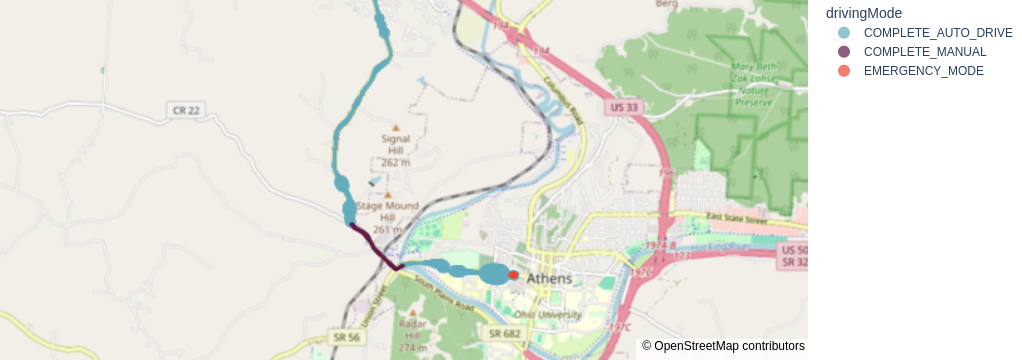

In [30]:
#Mapping driving mode to determine relationship between std dev, numberSatsInSolution and driving mode
fig = px.scatter_mapbox(merged_df.drop_duplicates(), lat="latitude", lon="longitude", hover_name="drivingMode", hover_data=["time","drivingMode", "numSatsInSolution",'solStatus'], 
                        color="drivingMode",
                        size="radius", size_max=16,
                        zoom=12, height=1000, mapbox_style="open-street-map",
                        color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         })

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

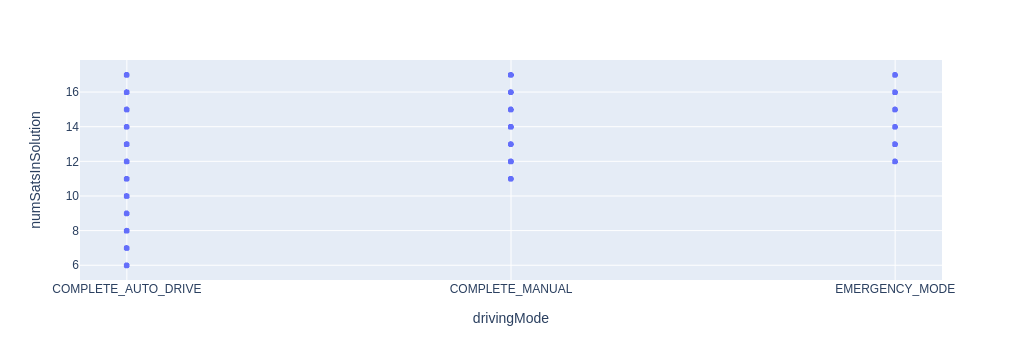

In [19]:
#Scatter plot to show relationship between driving mode and number of satellites
fig = px.scatter(merged_df, x="drivingMode", y="numSatsInSolution")
fig.show()

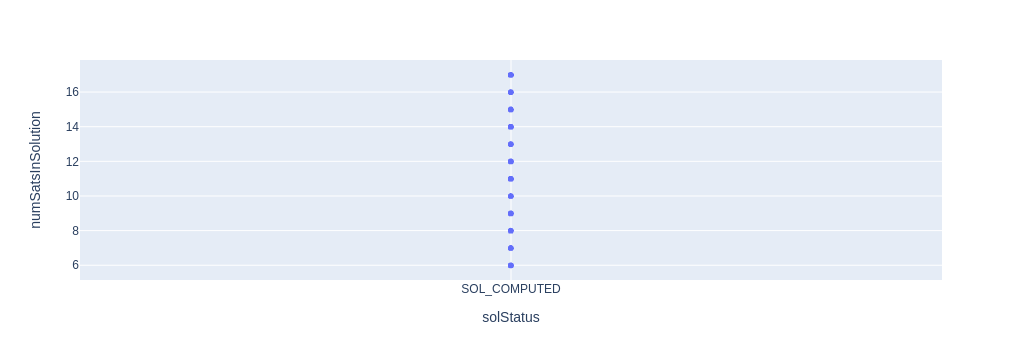

In [20]:
#Showing relationship between the satellite status and the number of satellites. 
fig = px.scatter(merged_df, x="solStatus", y="numSatsInSolution")
fig.show()

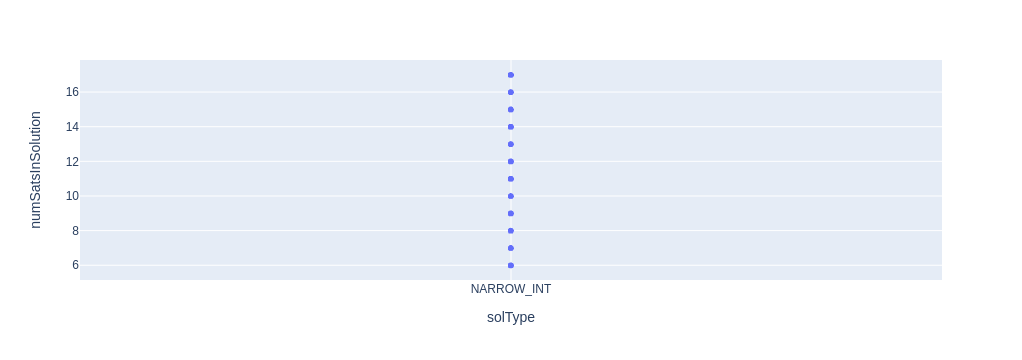

In [22]:
#Showing relationship between the satellite status and the number of satellites. 
fig = px.scatter(merged_df, x="solType", y="numSatsInSolution")
fig.show()

In [23]:
#Finding unique solStatus data
merged_df["solStatus"].unique()

array(['SOL_COMPUTED'], dtype=object)

In [24]:
#Finding unique solType data
merged_df["solType"].unique()

array(['NARROW_INT'], dtype=object)